<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/classify_with_vgg16_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Last amended: 23rd Feb, 2021
Ref: Page 143 (Section 5.3) of Book 'Deep Learning with python'
     by Francois Chollet
     https://www.kaggle.com/rajmehra03/a-comprehensive-guide-to-transfer-learning#data
Objective:
         i) Transfer Learning:     Building powerful image classification
                                   models using very little data using
                                   pre-trained applications
         ii) Feature Enngineering: Using engineered features with
                                   Random Forest Classifier
         iii)Learning Rate Annealing:Moderating Learning rate
                                     on/near plateau                      

Steps:
	1.   Create higher level abstract features from train data
       and save these to file
	2.   Use saved features as input to a FC model to make predictions
  3. Save FC model
  4. Use the complete model to make predictions

Data from Kaggle: https://www.kaggle.com/c/dogs-vs-cats/data

In our setup, we:
- created a folder: Images/cats_dogs/ folder
- created train/ and validation/ subfolders inside cats_dogs/
- created cats/ and dogs/ subfolders inside train/ and validation/

In summary, this is our directory structure:

Images/
	data/
	    train/
        	dogs/
        	    dog001.jpg
        	    dog002.jpg
        	    ...
        	cats/
        	    cat001.jpg
        	    cat002.jpg
        	    ...
	    validation/
        	dogs/
        	    dog001.jpg
        	    dog002.jpg
        	    ...
        	cats/
        	    cat001.jpg
        	    cat002.jpg
        	    ...

	$ source activate tensorflow
	$ ipython

'''

## PART I: Extract features from train data

In [ ]:
####********************************************************************************
#### *****************   PART I: Tranform train data to abstract features and save**
####********************************************************************************

#### Call libraries

In [1]:
%reset -f
## 1. Call libraries
import numpy as np

# 1.1 Classes for creating models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense

# 1.2 Class for accessing pre-built models
from tensorflow.keras import applications

# 1.3 Class for generating infinite images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1.4 Miscelleneous
import matplotlib.pyplot as plt
import time, os

In [27]:
# 1.5 Display multiple commands outputs from a sell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Bringing file from Google drive to VM
And unzip it there

In [2]:
#2.0 Copy file cats_dogs.tar.gz to our HOME folder
! cp /content/drive/MyDrive/Colab_data_files/cats_dogs.tar.gz $HOME

In [3]:
#2.0.1 Check if file copied. If so, unzip it
!ls $HOME

cats_dogs.tar.gz


In [4]:
# 2.0.2 We will keep our unzipped files here
!mkdir $HOME/data

In [5]:
# 2.0.3 Untar the gz file

! tar -xvzf $HOME/cats_dogs.tar.gz -C $HOME/data/

cats_dogs/train/cats/cat.637.jpg
cats_dogs/train/cats/cat.540.jpg
cats_dogs/validation/cats/cat.1374.jpg
cats_dogs/train/dogs/dog.95.jpg
cats_dogs/validation/dogs/dog.1297.jpg
cats_dogs/train/cats/cat.698.jpg
cats_dogs/train/cats/cat.828.jpg
cats_dogs/train/cats/cat.54.jpg
cats_dogs/train/cats/cat.249.jpg
cats_dogs/validation/cats/cat.1116.jpg
cats_dogs/train/dogs/dog.257.jpg
cats_dogs/validation/dogs/dog.1039.jpg
cats_dogs/train/cats/cat.152.jpg
cats_dogs/train/dogs/dog.984.jpg
cats_dogs/train/cats/cat.1000.jpg
cats_dogs/validation/dogs/dog.1220.jpg
cats_dogs/validation/cats/cat.1177.jpg
cats_dogs/train/cats/cat.909.jpg
cats_dogs/train/cats/cat.873.jpg
cats_dogs/train/dogs/dog.726.jpg
cats_dogs/train/cats/cat.621.jpg
cats_dogs/validation/dogs/dog.1281.jpg
cats_dogs/train/dogs/dog.917.jpg
cats_dogs/train/cats/cat.812.jpg
cats_dogs/test/test/234.jpg
cats_dogs/validation/cats/cat.1100.jpg
cats_dogs/train/dogs/dog.787.jpg
cats_dogs/train/dogs/dog.241.jpg
cats_dogs/validation/dogs/dog.1023

In [6]:
! ls /root/data

cats_dogs


In [8]:
# Check the folders/files
!ls -la $HOME/data/cats_dogs
# And where is my HOME?
! echo $HOME    # /root

total 20
drwxrwxr-x 5 1000 1000 4096 Feb  7  2018 .
drwxr-xr-x 3 root root 4096 Feb 23 23:47 ..
drwxrwxr-x 3 1000 1000 4096 Feb  7  2018 test
drwxrwxr-x 4 1000 1000 4096 Feb  7  2018 train
drwxrwxr-x 4 1000 1000 4096 Feb  7  2018 validation
/root


### AA. Constants & Hyperparameters

In [9]:
############################# AA. Constants & Hyperparameters ###################3
## 3. Constants/hyperparameters

# 3.1 Where are cats and dogs?
#train_data_dir = "C:\\Users\\ashok\\Desktop\\chmod\\2. data_augmentation\\cats_dogs\\train"
#train_data_dir      =  '/home/ashok/Images/cats_dogs/train'
train_data_dir = "/root/data/cats_dogs/train"

#validation_data_dir = "C:\\Users\\ashok\\Desktop\\chmod\\2. data_augmentation\\cats_dogs\\validation"
#validation_data_dir =  '/home/ashok/Images/cats_dogs/validation'
validation_data_dir = "/root/data/cats_dogs/validation"

# 3.2 Constrain dimensions of our 
#     images during image generation:

img_width, img_height = 75,75       # Large size images affect model-fitting speed


# 3.3 How many sampels of each one of them?

nb_train_samples, nb_validation_samples = 2000, 800


# 3.4 Predict in batches that fit RAM
#     and also sample-size is fully divisible by it

batch_size = 50         # Maybe for 4GB machine, batch-size of 32 will be OK


#### numpy .npy format?

A simple format for saving numpy arrays to disk with the full information about them.

The .npy format is the standard binary file format in NumPy for persisting a single arbitrary NumPy array on disk. The format stores all of the shape and dtype information necessary to reconstruct the array correctly even on another machine with a different architecture. The format is designed to be as simple as possible while achieving its limited goals.

The .npz format is the standard format for persisting multiple NumPy arrays on disk. A .npz file is a zip file containing multiple .npy files, one for each arra

In [19]:
# 3.5 File to which transformed bottleneck features
#     for train data wil be stored
#bf_filename = 'C:\\Users\\ashok\\Desktop\\chmod\\3. veryDeepConvNets\\models\\bottleneck_features_train.npy'
#bf_filename = '/home/ashok/.keras/models/bottleneck_features_train.npy'
bf_filename = '/root/data/cats_dogs/bottleneck_features_train.npy'

# 3.6 File to which transformed bottleneck features 
#     for validation data wil be stored
#val_filename = 'C:\\Users\\ashok\\Desktop\\chmod\\3. veryDeepConvNets\\models\\bottleneck_features_validation.npy'
val_filename = '/root/data/cats_dogs/bottleneck_features_validation.npy'


### BB. Data Augmentation

In [13]:
############################# BB. Data Generation ###################3

## 4. Data augmentation

# 4.1 Instanstiate an image data generator:
#     Needed to feed into the model

datagen_train = ImageDataGenerator(
                                    rescale=1. / 255,
                                    rotation_range=10,     # randomly rotate images in the range (degrees, 0 to 180)
                                    zoom_range = 0.1,      # Randomly zoom image 
                                    width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
                                    height_shift_range=0.2,# randomly shift images vertically (fraction of total height)
                                    horizontal_flip=True,  # randomly flip images
                                    vertical_flip=False   # randomly flip images
                                   )

# 4.2 Configure datagen_train further
#     Datagenerator is configured twice.
#     First configuration
#     is about image manipulation features
#     IInd configuration is regarding data source,
#     data classes, batchsize  etc

generator_tr = datagen_train.flow_from_directory(
              directory = train_data_dir,		      # Path to target train directory.
              target_size=(img_width, img_height),# Dimensions to which all images will be resized.
              batch_size=batch_size,              # At a time so many images will be output
              class_mode=None,                    # Return NO labels along with image data
              shuffle=False                       # Default shuffle = True
                                                  # Now images are picked up first from
                                                  #  one folder then from another; no shuffling
                                                  #   We will be using images NOT for
                                                  #    learning any model but only for prediction
                                                  #      so shuffle = False is OK as we now know
                                                  #       that Ist 1000 images are of one kind
                                                  #        and next 1000 images of another kind
                                                  # See: https://github.com/keras-team/keras/issues/3296
              )



Found 2000 images belonging to 2 classes.


In [ ]:

"""
# 4.2 If data was not arranged in the directory,
#     then iterator would be:

generator_t = datagen.flow(X_train,  # Should have rank 4. In case of grayscale data,
                                     #   the channels axis should have value 1, and in
                                     #    case of RGB data, it should have value 3.
                           y_train,  #  X_train labels
                           shuffle=False,
                           batch_size=batch_size
                        )

  There is, however, no 'target_size' parameter here

"""


#### Generation for validation data

In [14]:
# 4.3  Generator for validation data.
#      Initialize ImageDataGenerator object once more
#      shuffle = False => Sort data in alphanumeric order

datagen_val = ImageDataGenerator(rescale=1. / 255)
generator_val = datagen_val.flow_from_directory(
                                          validation_data_dir,
                                          target_size=(img_width, img_height),
                                          batch_size=batch_size,
                                          class_mode=None,
                                          shuffle=False   # Default shuffle = True
                                                      # Now images are picked up first from
                                                      #  one folder then from another; no shuffling
                                                      #   We will be using images NOT for
                                                      #    learning any model but only for prediction
                                                      #      so shuffle = False is OK as we now know
                                                      #       that Ist 1000 images are of one kind
                                                      #        and next 1000 images of another kind
                                                      # See: https://github.com/keras-team/keras/issues/3296
                                          )

Found 800 images belonging to 2 classes.


### CC. Modeling & Feature creation

In [ ]:
############################# CC. Modeling & Feature creation #####################
############################For both train and validation data ####################
####################Created features become our fresh train/validation data########

In [15]:
# 5. Buld VGG16 network model with 'imagenet' weights
#     Do not include the top FC layer of VGG16 model
#      Weights will be downloaded, if absent

model = applications.VGG16(
	                         include_top=False,
	                         weights='imagenet',
	                         input_shape=(img_width, img_height,3)
	                       )
# 5.1
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
______________________________________________________________

In [16]:
# 5.2 Feed images through VGG16 model in batches 
#     And make 'predictions' in 2000/50 = 40 steps.
#     Following takes time 7 +3 = 10 minutes
#     Note that there is no need for 'fit' method as weights are
#     already learnt

start = time.time()
# 4.1 By feeding the input samples from generator, 
#     create vgg16 output/predictions uptil the last
#     layer. We call it 'bottleneck features' as it
#     is not the desired end result
#     steps:  How many batches of images to output or how many times to call image-generator

bottleneck_features_train = model.predict_generator(
                                                    generator = generator_tr,
                                                    steps = nb_train_samples // batch_size,
                                                    verbose = 1
                                                    )
end = time.time()
print("Time taken: ",(end - start)/60, "minutes")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


40/40 [==============================] - 111s 3s/step
Time taken:  1.8482813278834025 minutes


In [17]:
# 5.3   Similarly, make predictions for 
#       validation data and extract features
#       Takes 12 minutes

start = time.time()
bottleneck_features_validation = model.predict_generator(
                                                         generator = generator_val,
                                                         steps = nb_validation_samples // batch_size,
                                                         verbose = 1
                                                         )

end = time.time()
print("Time taken: ",(end - start)/60, "minutes")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


16/16 [==============================] - 43s 3s/step
Time taken:  0.7224789619445801 minutes


### Saving Features

In [21]:
############################# DD. Saving features ###################

# 6. Save the train features
# 6.1 First delete the file to whcih we will save

if os.path.exists(bf_filename):
    os.system('rm ' + bf_filename)

# 6.2 Next save the train-features
np.save(open(bf_filename, 'wb'), bottleneck_features_train)


# 6.3 Save validation features from model
if os.path.exists(val_filename):
    os.system('rm ' + val_filename)

np.save(open(val_filename, 'wb'), bottleneck_features_validation)

# 6.4 Quit python so that complete memory is reset
#     Maybe reboot your lubuntu (NOT WINDOWS)


In [ ]:
# 7.0 Else, Let us delete some variables
del bottleneck_features_validation
del bottleneck_features_train
del model
del datagen_train
del datagen_val 

## PART-II Use Extracted features

In [1]:
################### ########### ##################### #######
################### PART-II BEGIN AGAIN #####################
################### ########### ##################### #######

#### Call libraries

In [52]:
## Part II: Load saved abstract features and proceed
#           with modeling and prediction
# Start ipython #

# 8.0 Call libraries
%reset -f
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import applications
import matplotlib.pyplot as plt
import time, os

#### Define constants

In [56]:
# 8.1 Hyperparameters/Constants
# 8.2 Dimensions of our images.
img_width, img_height = 75,75  # 150, 150
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 64
num_classes = 2

In [57]:
# 8.3 Where are saved bottleneck features for train data?
#bf_filename = '/home/ashok/.keras/models/bottleneck_features_train.npy'
#bf_filename = 'C:\\Users\\ashok\\Desktop\\chmod\\3. veryDeepConvNets\\models\\bottleneck_features_train.npy'
bf_filename = '/root/data/cats_dogs/bottleneck_features_train.npy'


# 8.4 Validation-bottleneck features filename
#val_filename = '/home/ashok/.keras/models/bottleneck_features_validation.npy'
#val_filename = 'C:\\Users\\ashok\\Desktop\\chmod\\3. veryDeepConvNets\\models\\bottleneck_features_validation.npy'
val_filename = '/root/data/cats_dogs/bottleneck_features_validation.npy'


#### HDF5 storage for Python?

The h5py package is a Pythonic interface to the HDF5 binary data format.

HDF5 lets you store huge amounts of numerical data, and easily manipulate that data from NumPy. For example, you can slice into multi-terabyte datasets stored on disk, as if they were real NumPy arrays. Thousands of datasets can be stored in a single file, categorized and tagged however you want.

In [ ]:
# 8.6 File to which FC model weights could be stored
#top_model_weights_path = "C:\\Users\\ashok\\Desktop\\chmod\\3. veryDeepConvNets\\models\\bottleneck_fc_model.h5"
#top_model_weights_path = '/home/ashok/.keras/models/bottleneck_fc_model.h5'
top_model_weights_path = '/root/data/cats_dogs/bottleneck_fc_model.h5'

#### Load Train data

In [58]:
# 9. Get train features
train_data_features = np.load(open(bf_filename,'rb'))

In [59]:
# 9.1
train_data_features.shape      # (2000, 2, 2, 512)
print("\n-----------\n")

# 9.2 Train lables. First half are of one kind and next half of other
#     Remember we had put 'shuffle = False' in data generators
#     1000 labels of one kind. Another 1000 labels of another kind
train_labels = np.array([1] * 1000 + [2] * 1000)   # Try [0] * 3 + [1] * 5
train_labels
print("\n-----------\n")

# 9.2.1
train_labels.shape     # (2000,)
print("\n-----------\n")

(2000, 2, 2, 512)


-----------



array([1, 1, 1, ..., 2, 2, 2])


-----------



(2000,)


-----------



##### Shuffle train data

In [60]:
# 9.3 Shuffle train features(tiles) as also corresponding labels
x = np.arange(2000)      # Generate 2000 indicies for shuffling
np.random.shuffle(x)     # x is inplace shuffled
x[:5]

# 9.4
train_data_features = train_data_features[x, :,:,:]
train_labels = train_labels[x]
train_labels.shape

array([ 906,  103, 1746, 1723, 1831])

(2000,)

##### OneHotEncode train labels

In [61]:
# 9.5 One hot encode the labels
#     For any classification problem, in Deep Learning
#     softmax layer rather than sigmoid MUST be used
#     See reasons at the end of code

train_labels_cat = to_categorical(train_labels  )
print("\n-----------\n")

train_labels_cat.shape    # (2000, 3)
print("\n-----------\n")

train_labels_cat          # Ist column is constant


-----------



(2000, 3)


-----------



array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [62]:
# 9.5.1 Ist constant column is of no use to us
#       So forget it
train_labels_cat = train_labels_cat[:, 1:]
train_labels_cat

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

#### Load Validation data

In [63]:
# 10. Read validation features
validation_data_features = np.load(open(val_filename,'rb'))


# 10.1
print("\n-----------\n")
validation_data_features.shape       # (800, 2, 2, 512)

# 10.2 Validation labels: half-half
validation_labels = np.array([1] * 400 + [2] * 400)

# 10.3 Convert to OHE
validation_labels = to_categorical(validation_labels)
validation_labels = validation_labels[:,1:]

# 10.4
print("\n-----------\n")
train_data_features.shape[1:]     # (2, 2, 512)


-----------



(800, 2, 2, 512)


-----------



(2, 2, 512)

#### Design our Model

The gist of RMSprop is to:
*    Maintain a moving (discounted) average of the square of gradients  
*    Divide the gradient by the root of this average


In [97]:
# 11.0 Delete any existing model
#      Perform model fitting with or without
#      'ReduceLROnPlateau'
# 
del model  

In [100]:
# 12. Plan model with FC layers only
#    We use transformed features as input to FC model
#    instead of actual train data

model = Sequential()
model.add(Flatten(input_shape=train_data_features.shape[1:]))     # (2, 2, 512)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# 12.1 Declare optimizer to use
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop
opt = tf.keras.optimizers.RMSprop(
                                   learning_rate=0.001,
                                   rho=0.9,      # Discount factor for coming gradient.  
                                   epsilon=1e-07,  # Small constant for numerical stability.
                                   name='RMSprop'
                                   )

# 12.2
model.compile(
              optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy']
              )


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 514       
Total params: 525,058
Trainable params: 525,058
Non-trainable params: 0
_________________________________________________________________


##### Reduce learning rate on plateau

In [101]:
# 12.3 Reduce learning rate when a metric has stopped improving.
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
                                               monitor='val_accuracy',
                                               factor = 0.1, # factor by which the learning
                                                             # rate will be reduced. 
                                                             # new_lr = lr * factor.
                                               min_delta=0.0001, # threshold for measuring the
                                                                 # new optimum, to only focus on 
                                                                 # significant changes. 
                                               patience=2, # number of epochs with no
                                                           # improvement after which 
                                                           # learning rate will be reduced. 
                                               verbose=1
                                              )

In [105]:
# 13.0 Fit model and make predictions on validation dataset
#      Takes 2 minutes
#      Watch Validation loss and Validation accuracy (around 81%)
#
start = time.time()
history = model.fit(
                    train_data_features, train_labels_cat,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks=[reduce_lr], 
                    validation_data=(validation_data_features, validation_labels),
                    verbose =1
                   )
end = time.time()
print("Time taken: ",(end - start)/60, "minutes")

Epoch 1/100
32/32 [==============================] - 1s 16ms/step - loss: 0.3452 - accuracy: 0.8545 - val_loss: 0.4309 - val_accuracy: 0.8075
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.3456 - accuracy: 0.8510 - val_loss: 0.4309 - val_accuracy: 0.8075
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.3466 - accuracy: 0.8575 - val_loss: 0.4309 - val_accuracy: 0.8075

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000001181490946e-25.
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.3435 - accuracy: 0.8520 - val_loss: 0.4309 - val_accuracy: 0.8075
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.3419 - accuracy: 0.8460 - val_loss: 0.4309 - val_accuracy: 0.8075

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000001428009978e-26.
Epoch 6/100
32/32 [==============================] - 0s 13ms/step - loss: 0.3435 - accuracy: 0.8550 - val_loss: 0.4309 - val_a

In [103]:
# 13.1
print("\n---History keys-----------\n")
history.history.keys()   # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# 13.1.1
print("\n---History tr accuracy length-----------\n")
len(history.history['accuracy'])     # 50  Training accuracy:
                                     # As many as number of epochs

#13.1.2
print("\n---History val accuracy length-----------\n")
len(history.history['val_accuracy']) # 50   Validation accuracy


---History keys-----------



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


---History tr accuracy length-----------



50


---History val accuracy length-----------



50

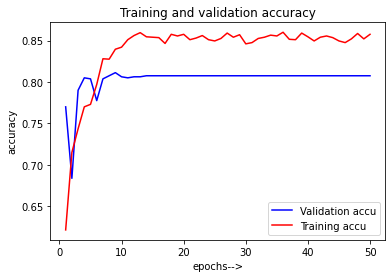

In [104]:
# 14.0 It is very wavy without
#     ReduceLROnPlateau

plot_learning_curve()

#### Save model

In [87]:
# 15. Finally save model weights for later use
model.save_weights(top_model_weights_path)

In [90]:
# 15.1 Check if saved and size of file:
! ls -la /root/data/cats_dogs/

total 24496
drwxrwxr-x 5 1000 1000     4096 Feb 24 00:39 .
drwxr-xr-x 3 root root     4096 Feb 23 23:47 ..
-rw-r--r-- 1 root root  2114080 Feb 24 01:21 bottleneck_fc_model.h5
-rw-r--r-- 1 root root 16384128 Feb 24 00:26 bottleneck_features_train.npy
-rw-r--r-- 1 root root  6553728 Feb 24 00:26 bottleneck_features_validation.npy
drwxrwxr-x 3 1000 1000     4096 Feb  7  2018 test
drwxrwxr-x 4 1000 1000     4096 Feb  7  2018 train
drwxrwxr-x 4 1000 1000     4096 Feb  7  2018 validation


#### Learning curve

In [85]:
#######################################################

#     How accuracy changes as epochs increase
#     We will use this function agai and again
#     in subsequent examples

def plot_learning_curve():
    val_acc = history.history['val_accuracy']
    tr_acc=history.history['accuracy']
    epochs = range(1, len(val_acc) +1)
    plt.plot(epochs,val_acc, 'b', label = "Validation accu")
    plt.plot(epochs, tr_acc, 'r', label = "Training accu")
    plt.title("Training and validation accuracy")
    plt.xlabel("epochs-->")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

#########################

# Use Random Forest
Making predictions using extracted features using Random Forest

In [ ]:
# 16.0 Using RandomForestClassifier for classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X= train_data_features
print("\n----X.shape-------\n")
X.shape      # (2000, 2, 2, 512)
X = X.reshape(2000, -1)
print("\n----X.shape-------\n")
X.shape     # (2000, 2048)
y = train_labels
print("\n-----y.shape------\n")
y.shape     # (2000, )

# 16.1
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, shuffle = True)
print("\n----y_train-------\n")
y_train[:5]     # It is now shuffled
print("\n----y_test-------\n")
y_test[:5]      # It is now shuffled
print("\n-----Model------\n")

# 16.2
model = RandomForestClassifier()
model.fit(X_train,y_train)
print("\n-----------\n")

# 16.3
y_pred = model.predict(X_test)
print("\n----y_pred-------\n")
y_pred[:10]
print("\n-----------\n")
np.sum(y_test==y_pred)/len(y_test)    # 79.8%
#===============================================

In [ ]:
#########################

"""
Sigmoid vs Softmax
===================

    Suppose there are 5 classes. So we may have either 5-sigmoid
    neurons at the output or just one neuron.
    If we have just one neuron, than the neuron will emit
    numbers as 4.3, 3.6 instead of 4 or 3. In a regression problem
    we can take exactly the value outputted that is 4.6 and subtract
    from expected output to calculate error. But in a classification
    problem, 4.6 is meaning less and we are not sure whether to consider
    it as 4th class or 5th class.

    If we want to have 5 neurons with sigmoid at the end then
    the better option is to have softmax.

    Therefore, in a classification problem, even if there
    are two classes, it is better to use softmax rather than use
    one sigmoid neuron at the end.

"""

In [ ]:
############ I am done #############